# Dynamic Averaging Results: Simple CNN

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from dyn_fed.utils.report_utils import generate_all_pivots, generate_packet_size_pivots
from dyn_fed.viz.report import plot_results, plot_pkt_size, plot_model_performance

rc('text', usetex=True)

In [3]:
project_dir = Path().resolve().parents[1]
project_dir

PosixPath('/Users/sashlinreddy/repos/masters/dyn-fed')

In [4]:
masters_dir = Path().resolve().parents[2]
masters_dir

PosixPath('/Users/sashlinreddy/repos/masters')

In [5]:
thesis_dir = (masters_dir/"fed-learn-thesis").resolve()
thesis_dir

PosixPath('/Users/sashlinreddy/repos/masters/fed-learn-thesis')

Join results

In [6]:
df1 = pd.read_csv(project_dir/"data/20200427-results.csv")
df2 = pd.read_csv(project_dir/"data/20200428-results.csv")
results = pd.concat([df1, df2]).reset_index(drop=True)

# Performance analysis

In [7]:
metrics = ['time', 'test_loss', 'test_acc', 'gen_gap', 'pkt_size', 'avg_comm_rate']

In [8]:
model = 'CNN'

## MNIST - SGD

In [9]:
dataset = 'MNIST'
optimizer = 'SGD'

In [10]:
results = results.query('n_clients < 64')

In [11]:
results.shape

(1760, 21)

In [12]:
results.head()

,jobid,dataset,model_type,optimizer,n_clients,agg_mode,interval,comm_mode,noniid,unbalanced,...,epochs,delta_threshold,error,time,train_acc,test_acc,train_loss,test_loss,pkt_size,comm_rounds
0,60576,fashion-mnist,logistic,adam,32,1,1,0,0,1,...,100,NaN,0,130.226681,82.9133,82.11,1.5907,1.5992,92.919,3100.0
1,60577,mnist,logistic,sgd,24,1,20,0,0,0,...,100,NaN,0,20.272419,83.5967,84.42,1.7588,1.7534,3.447,115.0
2,60578,mnist,logistic,sgd,8,1,20,0,1,1,...,100,NaN,0,41.749354,67.8100,68.67,1.5134,1.8902,1.049,35.0
3,60579,fashion-mnist,cnn1,adam,24,1,1,1,1,1,...,50,NaN,0,342.623015,75.6150,74.52,1.5820,1.7204,1831.963,692.0
4,60580,fashion-mnist,cnn1,adam,24,1,1,2,1,0,...,50,NaN,1,NaN,12.1133,12.21,2.3042,2.3043,NaN,NaN


In [13]:
results.loc[:, "avg_comm_rate"] = results["comm_rounds"] / (results["n_clients"] - 1)

In [14]:
results.loc[:, "gen_gap"] = (results["test_loss"] - results["train_loss"]) / ((results["test_loss"] + results["train_loss"]))

In [15]:
results.loc[:, "delta_threshold"] = results.delta_threshold.fillna(0.0)

In [16]:
drop_query = "(delta_threshold <= 0.0 or delta_threshold > 2.0) and comm_mode == 3"
adam_results = results.copy()
results = results.drop(results.query(drop_query).index).reset_index(drop=True)

In [17]:
cnn_mnist = results.query(
    "dataset == 'mnist' and model_type=='cnn1' and n_clients < 64"
    " and optimizer == 'sgd'"
)
cnn_fmnist = results.query(
    "dataset == 'fashion-mnist' and model_type=='cnn1' and n_clients < 64"
    " and optimizer == 'sgd'"
)

In [18]:
mnist_res, mnist_q = generate_all_pivots(cnn_mnist, metrics=metrics)

### Wall time

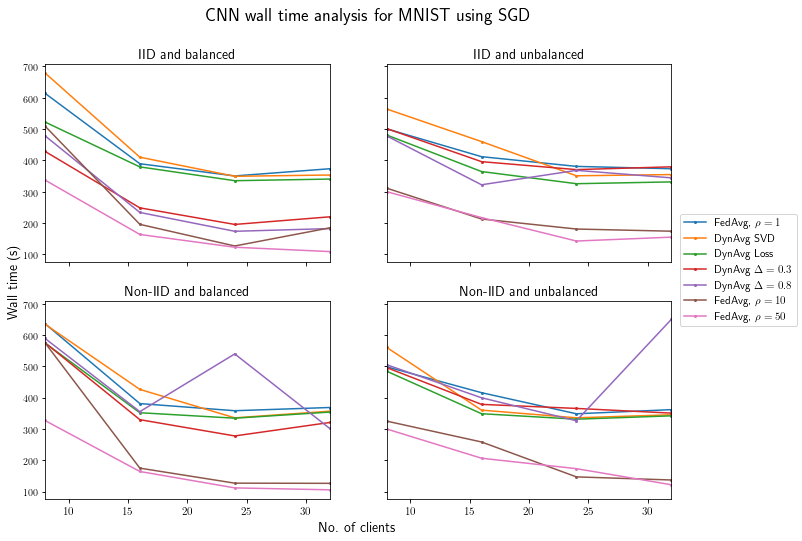

In [19]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    mnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for MNIST using SGD',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/cnn-mnist-sgd-time.png', dpi=500, format='png')

### Accuracy

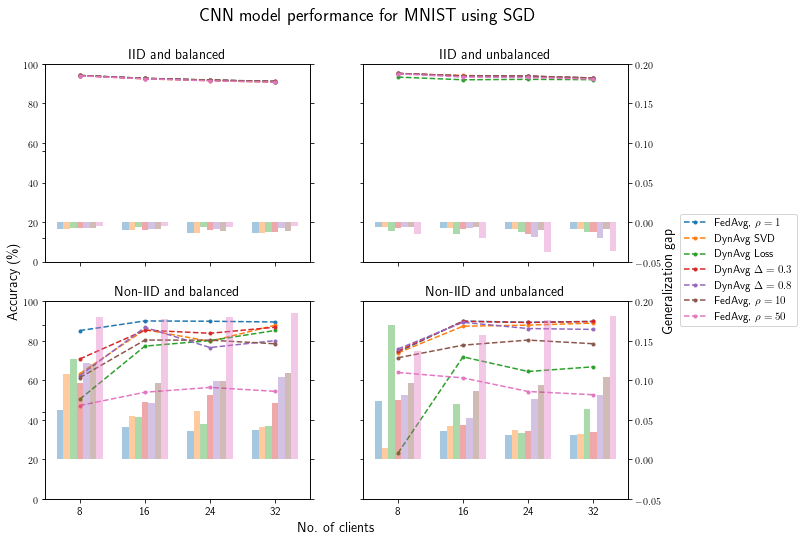

In [20]:
plot_model_performance(
    mnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for MNIST using {optimizer}'
)
plt.savefig(
    thesis_dir/f'figures/cnn-mnist-{optimizer.lower()}-mp.png',
    dpi=500,
    format='png'
)

In [21]:
# plot_results(
#     mnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for MNIST using SGD',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/cnn-mnist-sgd-acc.png', dpi=500, format='png')

### Generalization gap

In [22]:
# plot_results(
#     mnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for MNIST using SGD',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/cnn-mnist-sgd-gen-gap.png', dpi=500, format='png')

### Packet size

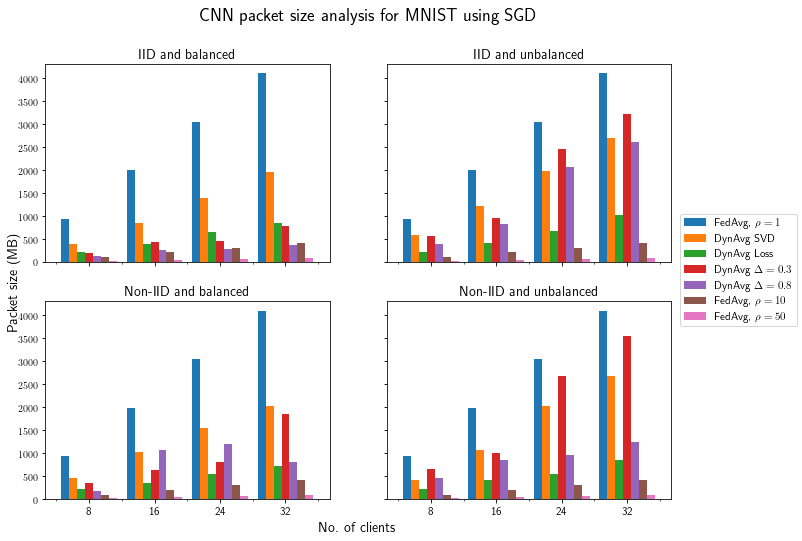

In [23]:
plot_results(
    mnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/cnn-mnist-sgd-pkt.png', dpi=500, format='png')

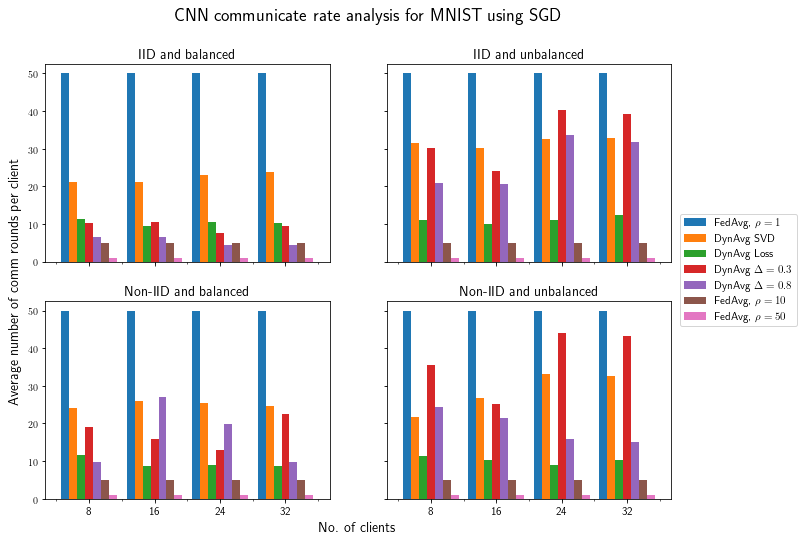

In [24]:
plot_results(
    mnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/cnn-mnist-sgd-cr.png', dpi=500, format='png')

## Fashion-MNIST - SGD

In [25]:
fmnist_res, fmnist_q = generate_all_pivots(cnn_fmnist, metrics=metrics)

### Wall time

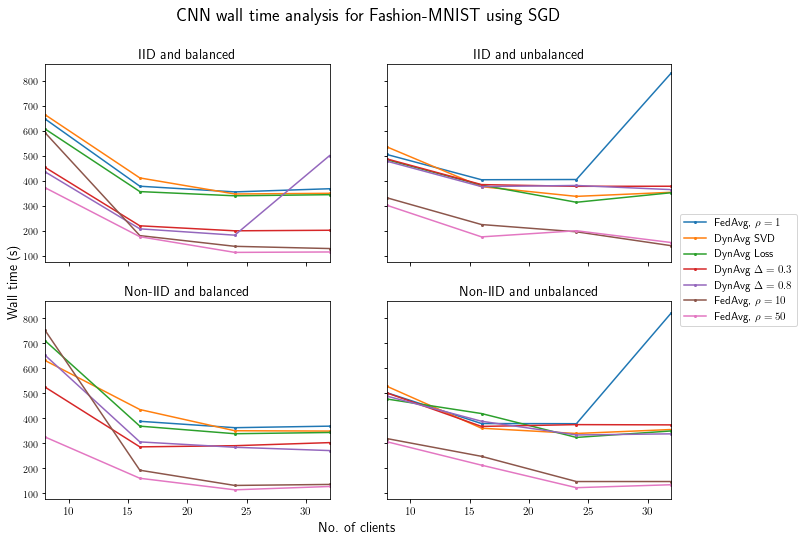

In [26]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    fmnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for Fashion-MNIST using SGD',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/cnn-fmnist-sgd-time.png', dpi=500, format='png')

### Accuracy

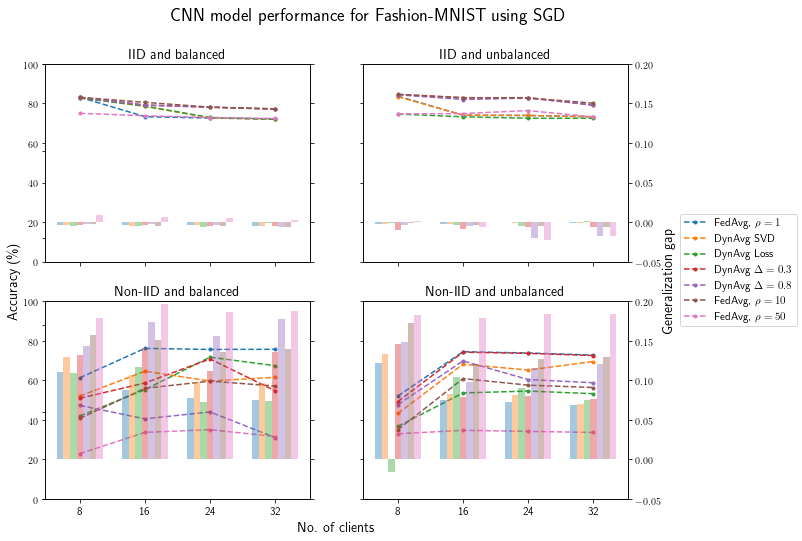

In [27]:
plot_model_performance(
    fmnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for Fashion-MNIST using SGD'
)
plt.savefig(thesis_dir/'figures/cnn-fmnist-sgd-mp.png', dpi=500, format='png')

In [28]:
# plot_results(
#     fmnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for Fashion-MNIST using SGD',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/cnn-fmnist-sgd-acc.png', dpi=500, format='png')

### Generalization gap

In [29]:
# plot_results(
#     fmnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for Fashion-MNIST using SGD',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/cnn-fmnist-sgd-gen-gap.png', dpi=500, format='png')

### Packet size

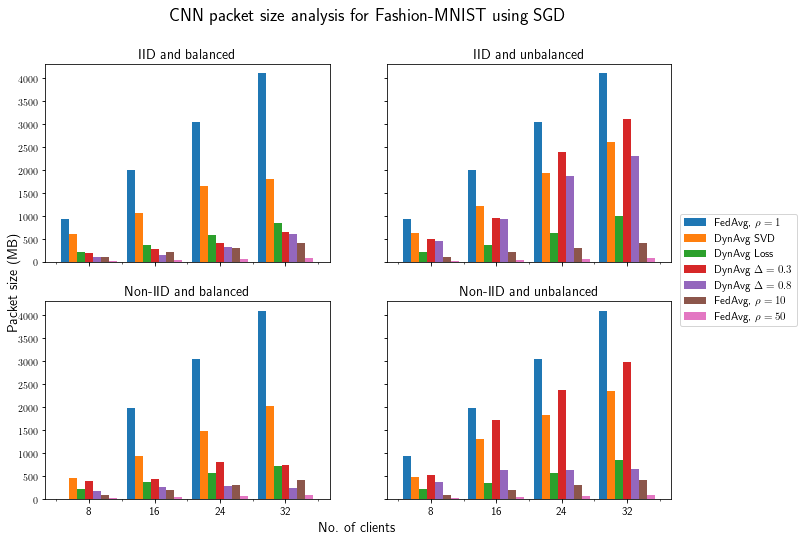

In [30]:
plot_results(
    fmnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for Fashion-MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/cnn-fmnist-sgd-pkt.png', dpi=500, format='png')

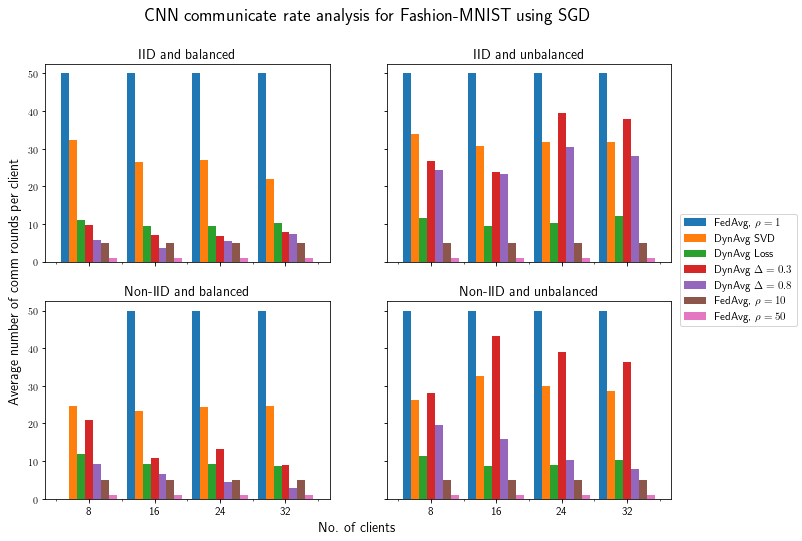

In [31]:
plot_results(
    fmnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for Fashion-MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/cnn-fmnist-sgd-cr.png', dpi=500, format='png')

## MNIST - Adam

In [32]:
drop_query = 'delta_threshold == 0.0  and comm_mode == 3'
adam_results = adam_results.drop(adam_results.query(drop_query).index).reset_index(drop=True)

In [33]:
optimizer = 'Adam'

In [34]:
cnn_mnist = adam_results.query(
    "dataset == 'mnist' and model_type=='cnn1' and n_clients < 64"
    " and optimizer == 'adam'"
)
cnn_fmnist = adam_results.query(
    "dataset == 'fashion-mnist' and model_type=='cnn1' and n_clients < 64"
    " and optimizer == 'adam'"
)

In [35]:
mnist_res, mnist_q = generate_all_pivots(cnn_mnist, metrics=metrics)

### Wall time

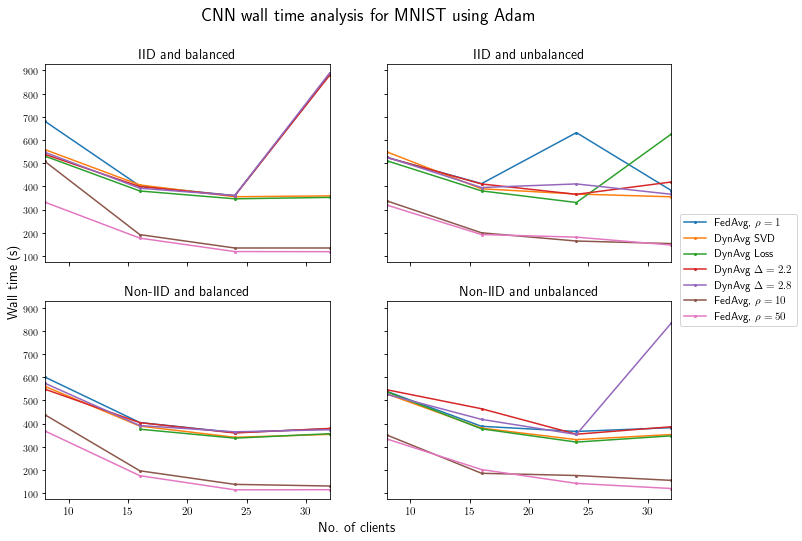

In [36]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    mnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/cnn-mnist-adam-time.png', dpi=500, format='png')

### Accuracy

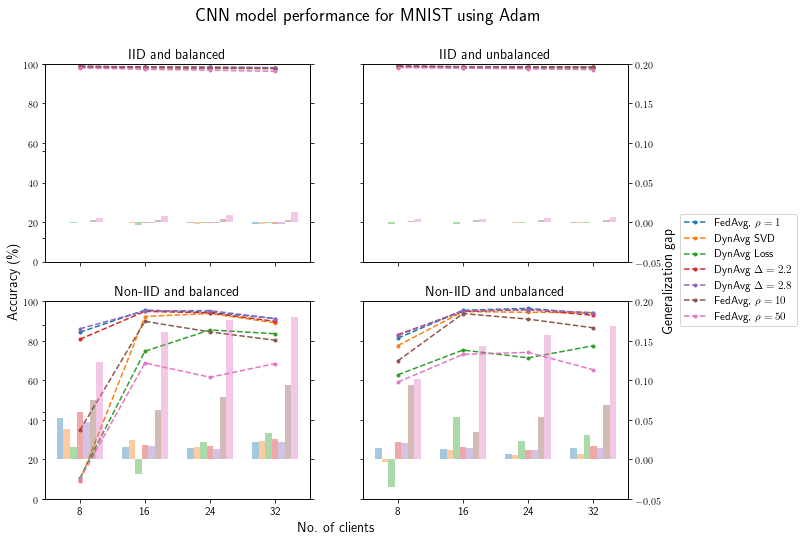

In [37]:
plot_model_performance(
    mnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for MNIST using {optimizer}'
)
plt.savefig(thesis_dir/f'figures/cnn-mnist-{optimizer.lower()}-mp.png', dpi=500, format='png')

In [38]:
# plot_results(
#     mnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for MNIST using Adam',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/cnn-mnist-adam-acc.png', dpi=500, format='png')

### Generalization gap

In [39]:
# plot_results(
#     mnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for MNIST using Adam',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/cnn-mnist-adam-gen-gap.png', dpi=500, format='png')

### Packet size

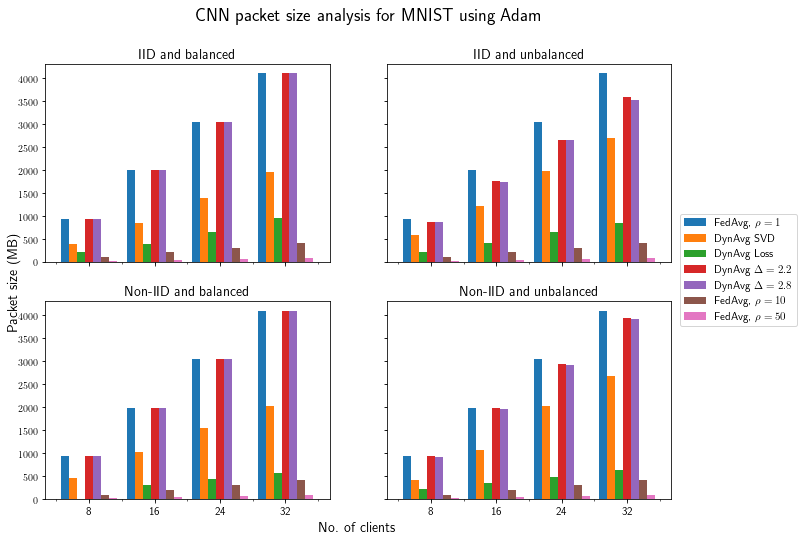

In [40]:
plot_results(
    mnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/cnn-mnist-adam-pkt.png', dpi=500, format='png')

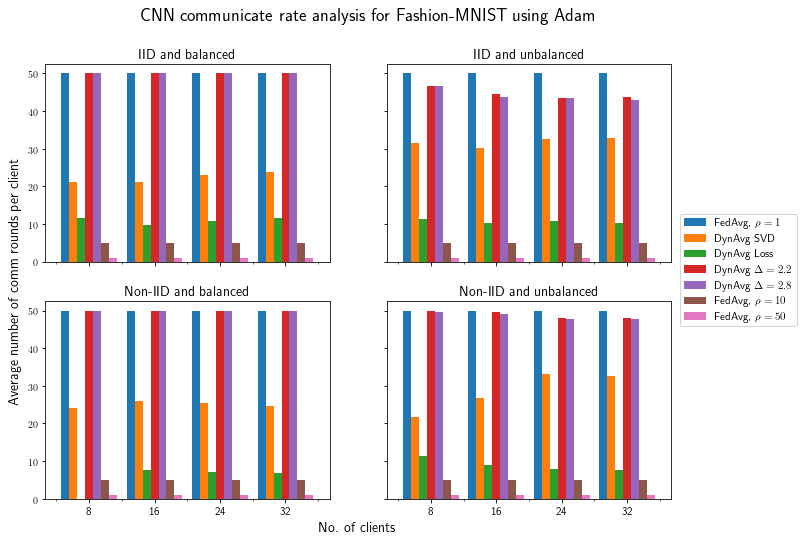

In [41]:
plot_results(
    mnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for Fashion-MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/cnn-mnist-adam-cr.png', dpi=500, format='png')

## Fashion-MNIST - Adam

In [42]:
fmnist_res, fmnist_q = generate_all_pivots(cnn_fmnist, metrics=metrics)

### Wall time

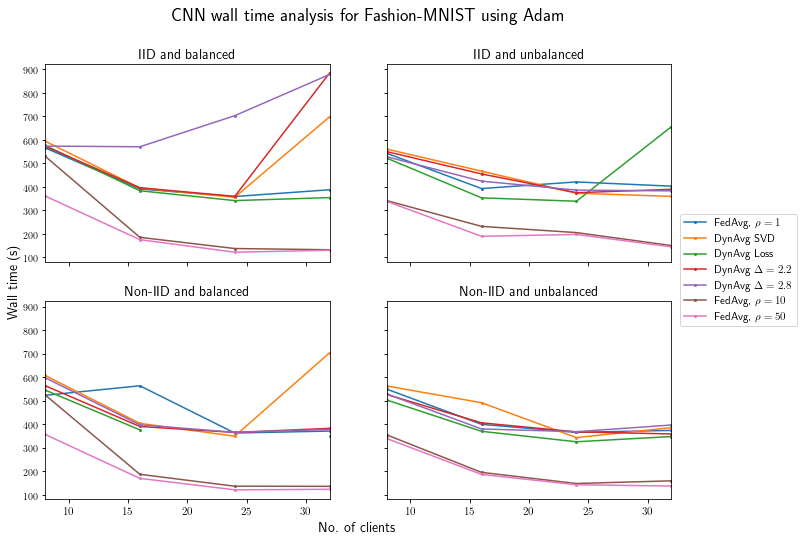

In [43]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    fmnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for Fashion-MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/cnn-fmnist-adam-time.png', dpi=500, format='png')

### Accuracy

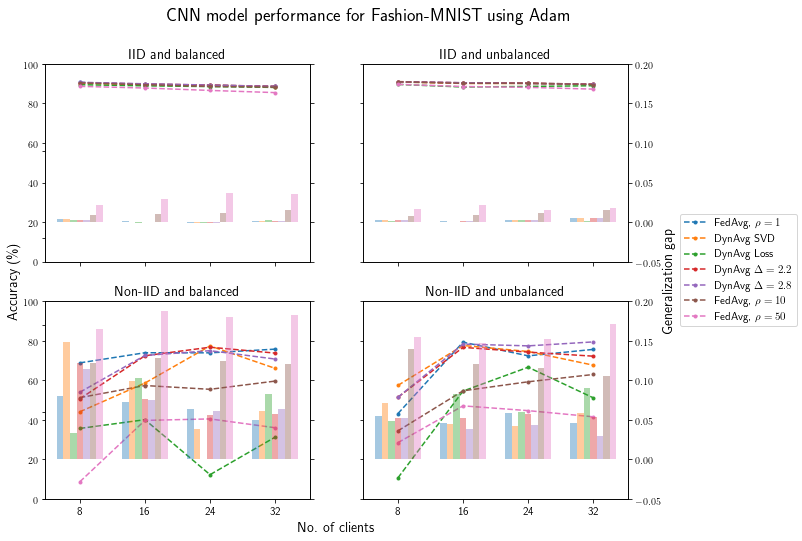

In [44]:
plot_model_performance(
    fmnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for Fashion-MNIST using {optimizer}'
)
plt.savefig(thesis_dir/f'figures/cnn-fmnist-{optimizer.lower()}-mp.png', dpi=500, format='png')

In [45]:
# plot_results(
#     fmnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for Fashion-MNIST using Adam',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/cnn-fmnist-adam-acc.png', dpi=500, format='png')

### Generalization gap

In [46]:
# plot_results(
#     fmnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for Fashion-MNIST using Adam',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/cnn-fmnist-adam-gen-gap.png', dpi=500, format='png')

### Packet size

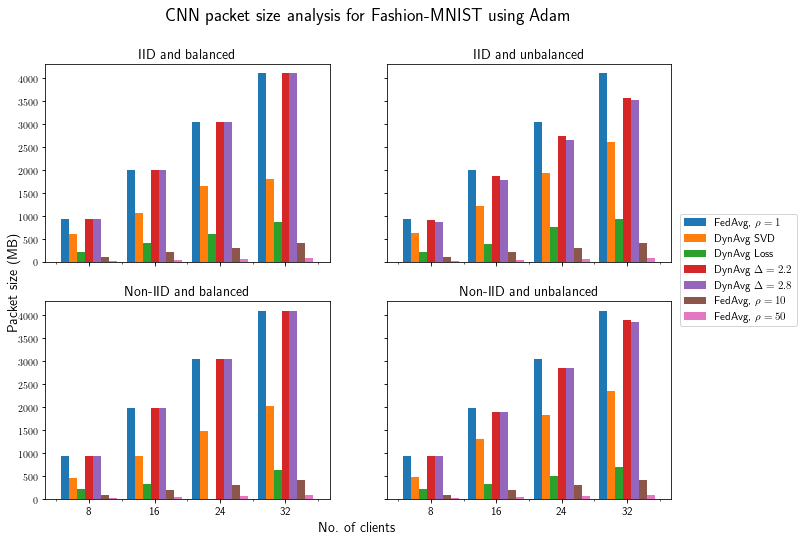

In [47]:
plot_results(
    fmnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for Fashion-MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/cnn-fmnist-adam-pkt.png', dpi=500, format='png')

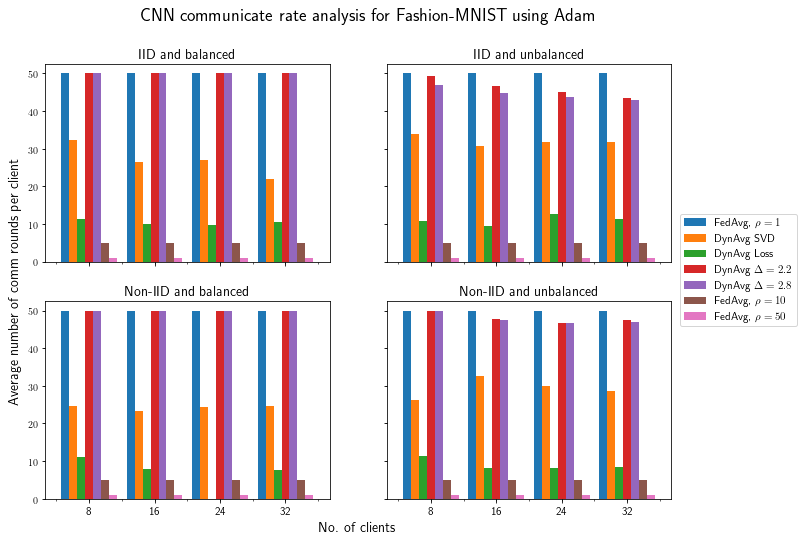

In [48]:
plot_results(
    fmnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for Fashion-MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/cnn-fmnist-adam-cr.png', dpi=500, format='png')